In [1]:
import numpy as np
import pandas as pd
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc

warnings.filterwarnings("ignore")
%matplotlib inline
from tensorflow.keras.layers import Input, Add, Dense, Layer, Activation, concatenate,Conv2D, Flatten, MaxPooling2D,BatchNormalization, Dropout
from keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
# Clear the session
# K.clear_session()

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class PrintShapeCallback(Callback):
    def __init__(self, model_layer_name):
        super(PrintShapeCallback, self).__init__()
        self.model_layer_name = model_layer_name

    def on_epoch_end(self, epoch, logs=None):
        # Get the output of the layer with the specified name
        layer_output = self.model.get_layer(self.model_layer_name).output
        print(f"After epoch {epoch+1}, shape of x (from layer {self.model_layer_name}): {layer_output.shape}")

print_shape_callback = PrintShapeCallback(model_layer_name='dense_1')  # Assuming 'dense_1' is the name of the Dense layer after h2(x)

class StopAtThresholdCallback(Callback):
    def __init__(self, threshold):
        super(StopAtThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss < self.threshold:
            print(f"\nStopping training as validation loss {val_loss} is below the threshold {self.threshold}")
            self.model.stop_training = True

# callback = StopAtThresholdCallback(threshold=1e-03)
callback = StopAtThresholdCallback(threshold=1.2962e-07)

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(mean=0.0,stddev=0.03),
                                trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return (self.b * (2 * x))/ (2**(1/2) * np.pi**(1/4))
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, **kwargs):
        super(H2Layer, self).__init__(**kwargs)

    def call(self, x, h1):
        return (((2*x*(h1)))-2)/(2*(np.pi**(1/4))*np.sqrt(math.factorial(2)))
    
class H3Layer(Layer):
    def __init__(self, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        
    def call(self, x, h1, h2):
        return (((2 * x * (h2)))-(4 * h1)) / (2**(3/2)*(np.pi**(1/4))*np.sqrt(math.factorial(3)))

class H4Layer(Layer):
    def __init__(self, **kwargs):
        super(H4Layer, self).__init__(**kwargs)

    def call(self, x, h2, h3):
        return (((2*x*(h3)))-(6*h2)) / (2**2 *(np.pi**(1/4))*np.sqrt(math.factorial(4)))

class H5Layer(Layer):
    def __init__(self, **kwargs):
        super(H5Layer,self).__init__(**kwargs)

    def call(self,x, h3, h4):
        return (((2 * x * h4)) - (8 * h3)) / (2**(5/2) * (np.pi**(1/4)) * np.sqrt(math.factorial(5)))

#FROM THIS ON NO MODIFICATION ON WEIGHTS
class H6Layer(Layer):
    def __init__(self, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        
    def call(self,x, h4, h5):
        return (2*x*(h5))-(10*h4)

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer=RandomNormal(mean=0.0,stddev=0.05),
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                        initializer=RandomNormal(mean=0.0,stddev=0.05),
                                        trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

 
class Relu_With_Weight(Layer):
    def __init__(self, **kwargs):
        super(Relu_With_Weight, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(),
                                trainable=True)
        super(Relu_With_Weight, self).build(input_shape)

    def call(self, x):
        return K.tanh(x * self.b)

2024-06-12 13:35:15.692832: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 13:35:15.775189: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-12 13:35:15.797249: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-12 13:35:16.223980: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Training data shape: (50000, 32, 32, 3) (50000, 10)
Test data shape: (10000, 32, 32, 3) (10000, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 3)   12          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['batch_normalization[0][0]']    
                                                                                              

2024-06-05 15:15:17.917792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-05 15:15:17.932135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-05 15:15:17.932264: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-05 15:15:17.932651: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Epoch 1/30


2024-06-05 15:15:19.340874: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2024-06-05 15:15:19.429713: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


391/391 [==============================] - 5s 11ms/step - loss: 1.8381 - accuracy: 0.3254 - val_loss: 1.4678 - val_accuracy: 0.4727
Epoch 2/30
391/391 [==============================] - 4s 10ms/step - loss: 1.4178 - accuracy: 0.4881 - val_loss: 1.2505 - val_accuracy: 0.5530
Epoch 3/30
391/391 [==============================] - 4s 10ms/step - loss: 1.2827 - accuracy: 0.5420 - val_loss: 1.1271 - val_accuracy: 0.5966
Epoch 4/30
391/391 [==============================] - 4s 10ms/step - loss: 1.2005 - accuracy: 0.5725 - val_loss: 1.0886 - val_accuracy: 0.6132
Epoch 5/30
391/391 [==============================] - 4s 10ms/step - loss: 1.1404 - accuracy: 0.5960 - val_loss: 1.0250 - val_accuracy: 0.6425
Epoch 6/30
391/391 [==============================] - 4s 10ms/step - loss: 1.0959 - accuracy: 0.6115 - val_loss: 0.9938 - val_accuracy: 0.6500
Epoch 7/30
391/391 [==============================] - 4s 10ms/step - loss: 1.0540 - accuracy: 0.6282 - val_loss: 0.9684 - val_accuracy: 0.6659
Epoch 8/30

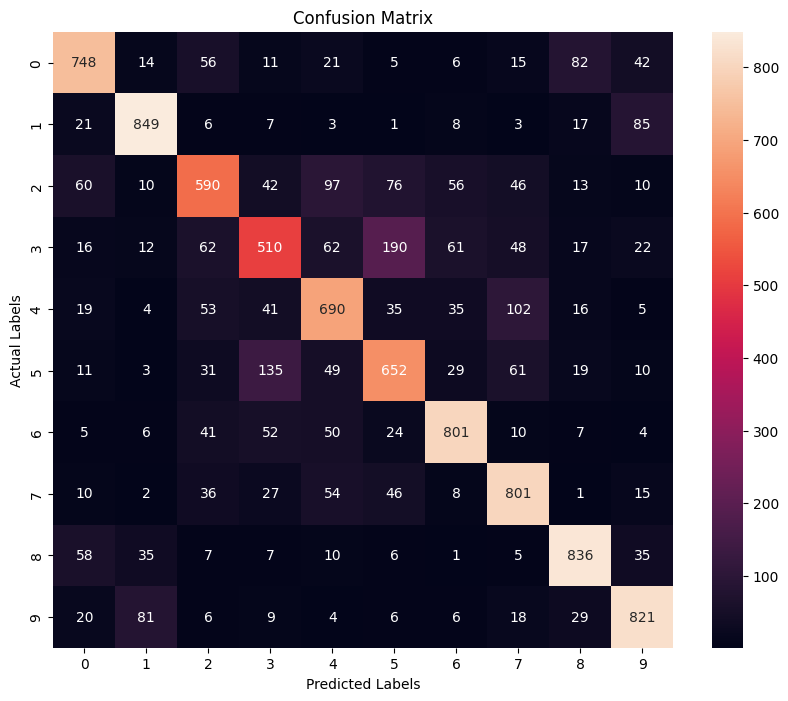

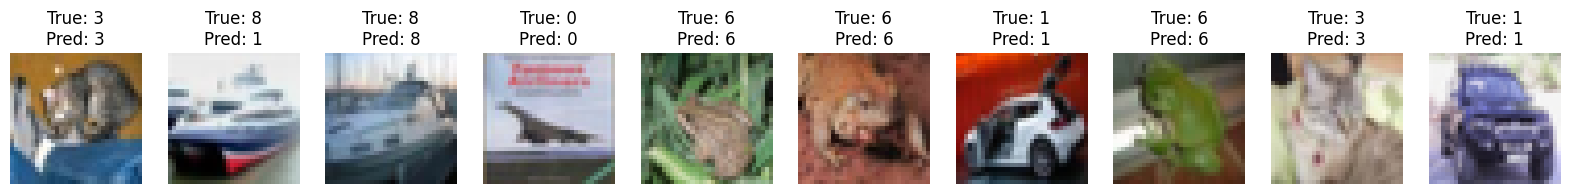

In [2]:
import tensorflow as tf
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from tensorflow_addons.layers import WeightNormalization
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to a 0 to 1 range
X_train, X_val = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
y_train, y_val = to_categorical(y_train, 10), to_categorical(y_test, 10)

# Printing the shape of the dataset to confirm
print("Training data shape:", x_train.shape, y_train.shape)
print("Test data shape:", x_test.shape, y_test.shape)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(X_train)

def build_model(input_shape, num_classes, filters):
    rank = 5
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()
    h4 = H4Layer()
    h5 = H5Layer()
    x = BatchNormalization()(x)

    # x = WeightNormalization(Conv2D(filters=filters, kernel_size=(7,7), strides=2, padding='same',kernel_initializer="he_normal"))(x)
    x = Conv2D(filters=filters, kernel_size=(7,7), strides=2, padding='same',kernel_initializer="he_normal")(x)

    x = x_h1 = h1(x)
    x = Conv2D(filters=filters, kernel_size=(5, 5), padding='same',kernel_initializer="he_normal")(x)
    
    #x = TensorDecompositionLayer(rank)(x)
    x = x_h2 = h2(x,x_h1)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same',kernel_initializer="he_normal")(x)
    #x = TensorDecompositionLayer(rank)(x)
    x = x_h3 = h3(x,x_h1,x_h2)
    # x = WeightNormalization(Conv2D(filters=filters, kernel_size=(3, 3), padding='same',kernel_initializer="he_normal"))(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same',kernel_initializer="he_normal")(x)
    x = x_h4 = h4(x,x_h2,x_h3)
    # x = Conv2D(filters=64, kernel_size=(3, 3), padding='same',kernel_initializer="he_normal")(x)
    # x = x_h5 = h5(x,x_h3,x_h4)

    x = MaxPooling2D((4,4))(x)
    x = Dropout(rate=0.5)(x)

    x = Flatten()(x)

    output_layer = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (32, 32, 3) # CIFAR-10 images size
num_classes = 10 # Number of classes in CIFAR-10
model_img = build_model(input_shape, num_classes, 64)
model_img.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model_img.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 128
epochs = 30

history = model_img.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = model_img.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_test = X_val
y_true = y_val
y_pred = model_img.predict(X_test)

# Assuming y_true and y_pred are already one-hot encoded, convert them back to class labels
y_true_labels = np.argmax(y_true, axis=1)
y_pred = model_img.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Plotting a confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Displaying a few images with their predictions
num_samples = 10  # Number of samples to display
fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))

for i, ax in enumerate(axes):
    ax.imshow(X_test[i])  # Show the image
    ax.set_title(f"True: {y_true_labels[i]}\nPred: {y_pred_labels[i]}")
    ax.axis('off')

plt.show()

def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


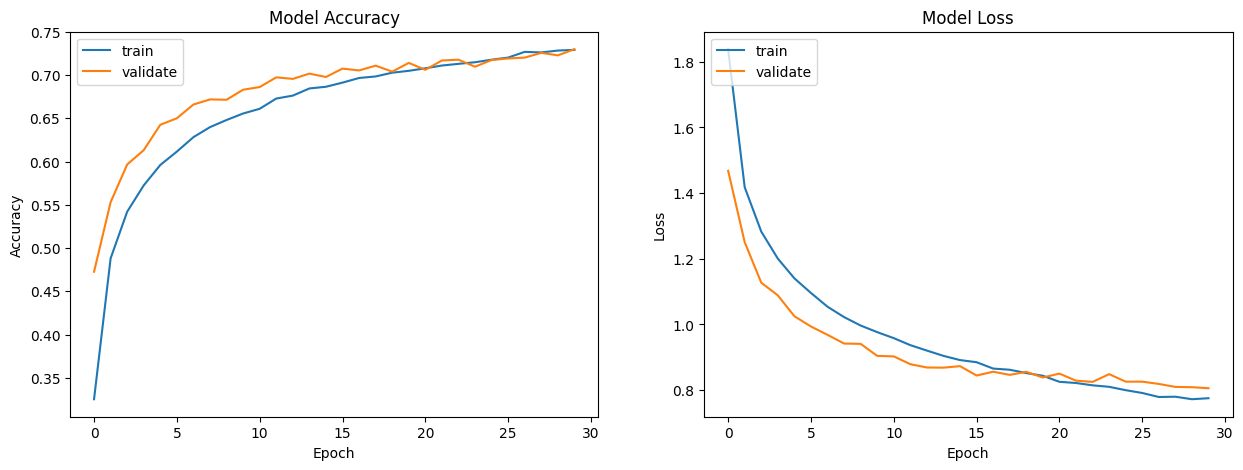

In [ ]:
# Clear the session to free up GPU memory
tf.keras.backend.clear_session()

#FORGET PREVIOUS MODEL
del model_img
gc.collect()

## Padding with (1,1) all kernel size 3,3

Training data shape: (50000, 32, 32, 3) (50000, 10)
Test data shape: (10000, 32, 32, 3) (10000, 1)


2024-06-10 15:38:35.152864: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-10 15:38:35.167975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-10 15:38:35.168101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-10 15:38:35.168497: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 3)   12          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   4736        ['batch_normalization[0][0]']    
                                                                                                  
 h1_layer (H1Layer)             (None, 16, 16, 32)   32          ['conv2d[0][0]']             

2024-06-10 15:38:36.808180: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2024-06-10 15:38:36.852883: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


391/391 [==============================] - 10s 23ms/step - loss: 1.8390 - accuracy: 0.3292 - val_loss: 1.5935 - val_accuracy: 0.4294
Epoch 2/30
391/391 [==============================] - 9s 22ms/step - loss: 1.4571 - accuracy: 0.4798 - val_loss: 1.2951 - val_accuracy: 0.5461
Epoch 3/30
391/391 [==============================] - 9s 22ms/step - loss: 1.3247 - accuracy: 0.5292 - val_loss: 1.1768 - val_accuracy: 0.5834
Epoch 4/30
391/391 [==============================] - 9s 22ms/step - loss: 1.2309 - accuracy: 0.5621 - val_loss: 1.1038 - val_accuracy: 0.6153
Epoch 5/30
391/391 [==============================] - 9s 22ms/step - loss: 1.1723 - accuracy: 0.5856 - val_loss: 1.0658 - val_accuracy: 0.6228
Epoch 6/30
391/391 [==============================] - 9s 22ms/step - loss: 1.1233 - accuracy: 0.6068 - val_loss: 1.0320 - val_accuracy: 0.6423
Epoch 7/30
391/391 [==============================] - 9s 22ms/step - loss: 1.0848 - accuracy: 0.6194 - val_loss: 0.9726 - val_accuracy: 0.6689
Epoch 8/3

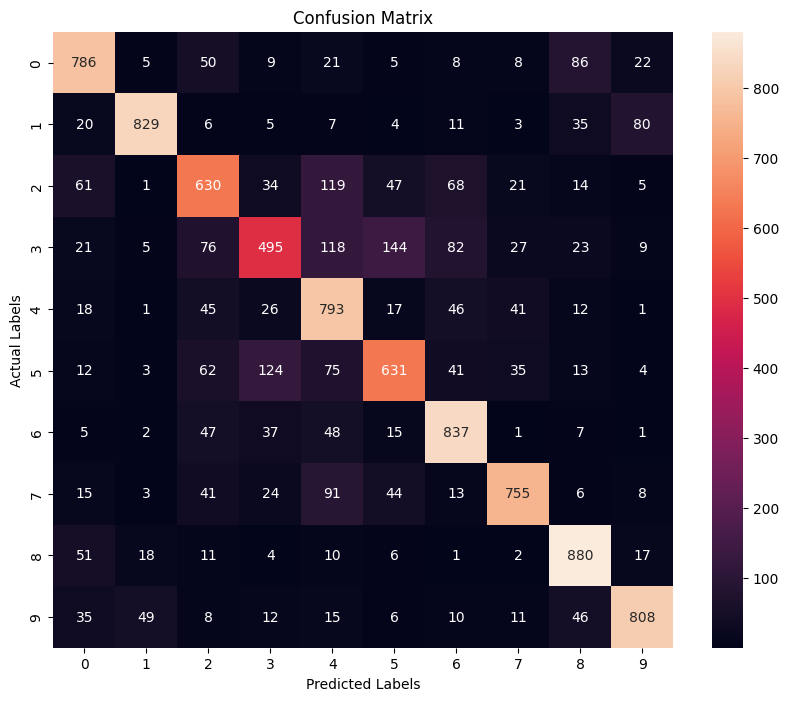

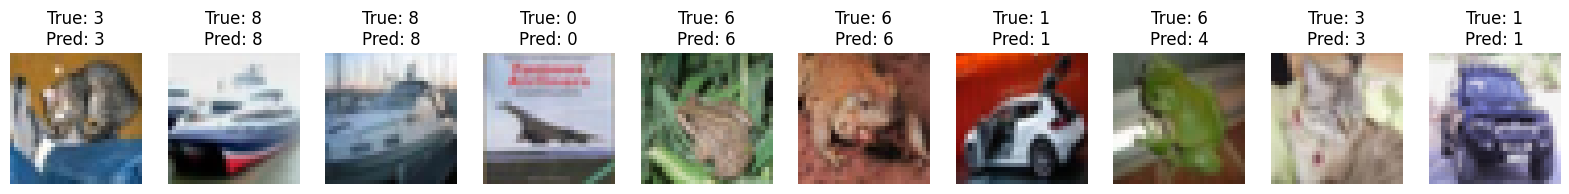

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


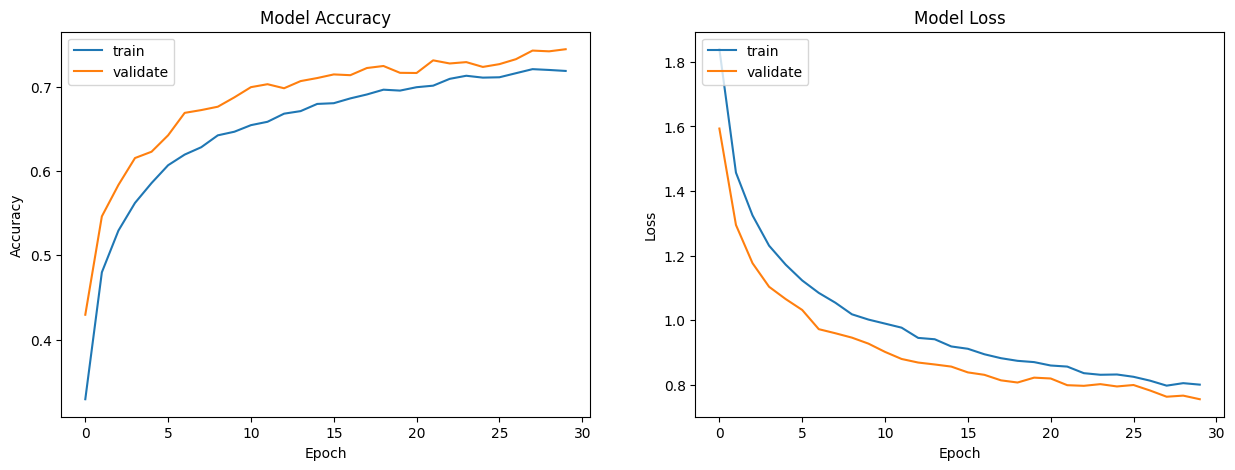

In [2]:
import tensorflow as tf
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from tensorflow_addons.layers import WeightNormalization
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to a 0 to 1 range
X_train, X_val = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
y_train, y_val = to_categorical(y_train, 10), to_categorical(y_test, 10)

# Printing the shape of the dataset to confirm
print("Training data shape:", x_train.shape, y_train.shape)
print("Test data shape:", x_test.shape, y_test.shape)

def build_model(input_shape, num_classes, filters):
    rank = 5
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()
    h4 = H4Layer()
    h5 = H5Layer()
    x = BatchNormalization()(x)

    x = Conv2D(filters=32, kernel_size=(7, 7), strides=2, padding='same', kernel_initializer="he_normal")(x)
    x = x_h1 = h1(x)
    x_h1 = Conv2D(filters=64,kernel_size=(1, 1), padding='same')(x_h1)  # Ensure h1 and x have the same number of filters
    x = Conv2D(filters=64, kernel_size=(5, 5), padding='same', kernel_initializer="he_normal")(x)
    x = x_h2 = h2(x, x_h1)
    x_h1 = Conv2D(filters=128,kernel_size=(1, 1), padding='same')(x_h1)  # Ensure h1 and x have the same number of filters
    x_h2 = Conv2D(filters=128, kernel_size=(1, 1), padding='same')(x_h2)  # Ensure h2 and x have the same number of filters
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_initializer="he_normal")(x)
    x = x_h3 = h3(x, x_h1, x_h2)
    x = Dropout(rate=0.5)(x)
    x_h2 = Conv2D(filters=256, kernel_size=(1, 1), padding='same')(x_h2)  # Ensure h2 and x have the same number of filters
    x_h3 = Conv2D(filters=256, kernel_size=(1, 1), padding='same')(x)  # Ensure h3 and x have the same number of filters
    x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', kernel_initializer="he_normal")(x)
    x = x_h4 = h4(x, x_h2, x_h3)

    x = MaxPooling2D((4, 4))(x)
    x = Dropout(rate=0.5)(x)

    x = Flatten()(x)

    x = Dropout(rate=0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (32, 32, 3) # CIFAR-10 images size
num_classes = 10 # Number of classes in CIFAR-10
model_img = build_model(input_shape, num_classes, 64)
model_img.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model_img.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 128
epochs = 30

history = model_img.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = model_img.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_test = X_val
y_true = y_val
y_pred = model_img.predict(X_test)

# Assuming y_true and y_pred are already one-hot encoded, convert them back to class labels
y_true_labels = np.argmax(y_true, axis=1)
y_pred = model_img.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Plotting a confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Displaying a few images with their predictions
num_samples = 10  # Number of samples to display
fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))

for i, ax in enumerate(axes):
    ax.imshow(X_test[i])  # Show the image
    ax.set_title(f"True: {y_true_labels[i]}\nPred: {y_pred_labels[i]}")
    ax.axis('off')

plt.show()

def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

## Remove stride, use MaxPooling (2,2), ADDED IN BETWEEN LAYERS DROPPOUT

Training data shape: (50000, 32, 32, 3) (50000, 10)
Test data shape: (10000, 32, 32, 3) (10000, 1)


2024-06-10 14:44:15.219549: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-10 14:44:15.235934: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-10 14:44:15.236074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-10 14:44:15.236474: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 3)   12          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 256)  37888       ['batch_normalization[0][0]']    
                                                                                                  
 h1_layer (H1Layer)             (None, 32, 32, 256)  256         ['conv2d[0][0]']             

2024-06-10 14:44:16.945684: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2024-06-10 14:44:17.038410: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


196/196 [==============================] - 15s 69ms/step - loss: 1.9088 - accuracy: 0.2920 - val_loss: 1.9890 - val_accuracy: 0.2508
Epoch 2/30
196/196 [==============================] - 13s 66ms/step - loss: 1.5516 - accuracy: 0.4307 - val_loss: 1.3996 - val_accuracy: 0.5061
Epoch 3/30
196/196 [==============================] - 13s 66ms/step - loss: 1.4207 - accuracy: 0.4824 - val_loss: 1.2404 - val_accuracy: 0.5519
Epoch 4/30
196/196 [==============================] - 13s 66ms/step - loss: 1.3221 - accuracy: 0.5237 - val_loss: 1.1524 - val_accuracy: 0.5927
Epoch 5/30
196/196 [==============================] - 13s 67ms/step - loss: 1.2260 - accuracy: 0.5562 - val_loss: 1.0837 - val_accuracy: 0.6191
Epoch 6/30
196/196 [==============================] - 13s 66ms/step - loss: 1.1652 - accuracy: 0.5847 - val_loss: 1.0298 - val_accuracy: 0.6344
Epoch 7/30
196/196 [==============================] - 13s 66ms/step - loss: 1.1110 - accuracy: 0.6048 - val_loss: 0.9865 - val_accuracy: 0.6561
Epo

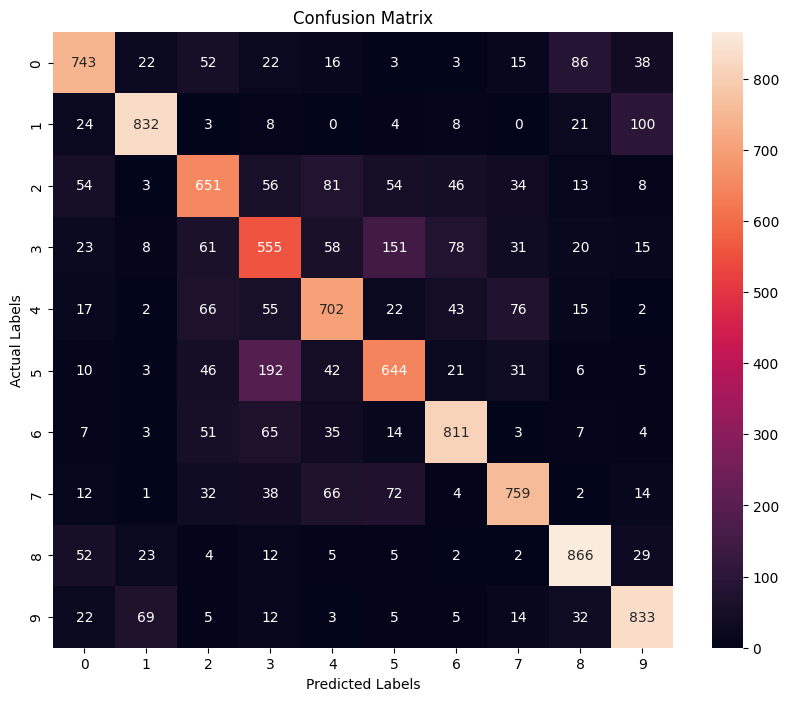

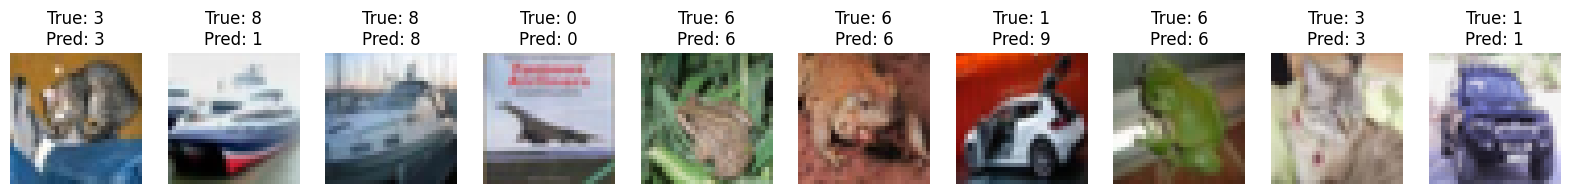

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


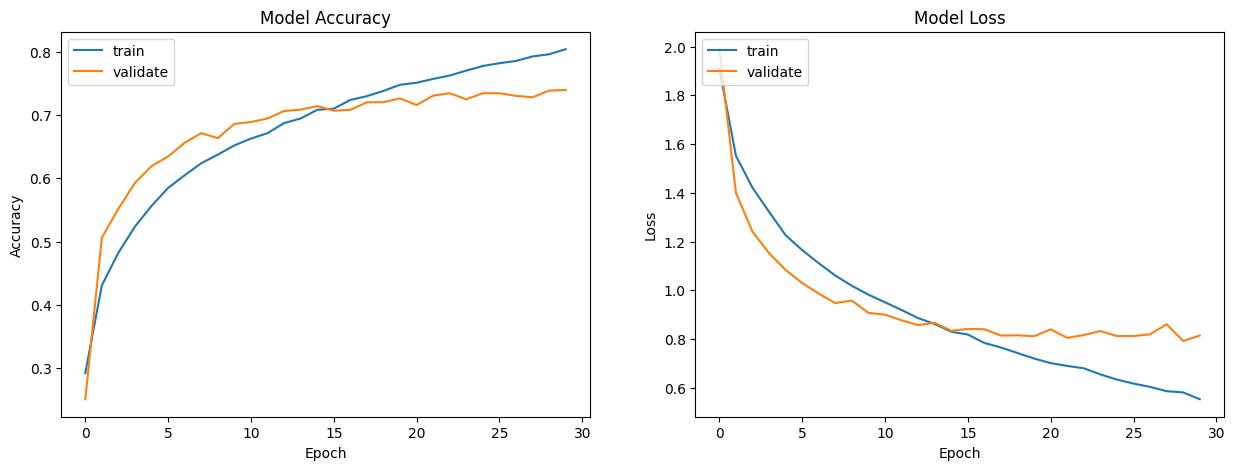

In [2]:
import tensorflow as tf
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from tensorflow_addons.layers import WeightNormalization
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to a 0 to 1 range
X_train, X_val = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
y_train, y_val = to_categorical(y_train, 10), to_categorical(y_test, 10)

# Printing the shape of the dataset to confirm
print("Training data shape:", x_train.shape, y_train.shape)
print("Test data shape:", x_test.shape, y_test.shape)

def build_model(input_shape, num_classes, filters):
    rank = 5
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()
    h4 = H4Layer()
    h5 = H5Layer()
    x = BatchNormalization()(x)

    x = Conv2D(filters=256, kernel_size=(7, 7), padding='same', kernel_initializer="he_normal")(x)
    # x = BatchNormalization()(x)  # Add batch normalization here
    x = x_h1 = h1(x)
    x = MaxPooling2D((2, 2))(x) # X BEING MAXPOOLED
    x_h1 = MaxPooling2D((2, 2))(x_h1) #H1 BEING MAXPOOLED
    x_h1 = Conv2D(filters=128,kernel_size=(1, 1), padding='same')(x_h1)  # Ensure h1 and x have the same number of filters
    # x_h1 = BatchNormalization()(x_h1)  # Add batch normalization here
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_initializer="he_normal")(x)
    # x = BatchNormalization()(x)  # Add batch normalization here
    x = x_h2 = h2(x, x_h1)
    x = MaxPooling2D((2, 2))(x)
    x_h1 = MaxPooling2D((2, 2))(x_h1)
    x_h2 = MaxPooling2D((2, 2))(x_h2)
    x_h1 = Conv2D(filters=64,kernel_size=(1, 1), padding='same')(x_h1)  # Ensure h1 and x have the same number of filters
    x_h2 = Conv2D(filters=64, kernel_size=(1, 1), padding='same')(x_h2)  # Ensure h2 and x have the same number of filters
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_initializer="he_normal")(x)
    x = x_h3 = h3(x, x_h1, x_h2)
    x = MaxPooling2D((2, 2))(x)
    x_h2 = MaxPooling2D((2, 2))(x_h2)
    x_h3 = MaxPooling2D((2, 2))(x_h3)
    x_h2 = Conv2D(filters=32, kernel_size=(1, 1), padding='same')(x_h2)  # Ensure h2 and x have the same number of filters
    x_h3 = Conv2D(filters=32, kernel_size=(1, 1), padding='same')(x)  # Ensure h3 and x have the same number of filters
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_initializer="he_normal")(x)
    x = x_h4 = h4(x, x_h2, x_h3)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(rate=0.4)(x)

    x = Flatten()(x)
    x = Dropout(rate=0.4)(x)  # Additional dropout layer before the dense layer


    output_layer = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (32, 32, 3) # CIFAR-10 images size
num_classes = 10 # Number of classes in CIFAR-10
model_img = build_model(input_shape, num_classes, 64)
model_img.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model_img.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 256
epochs = 30

history = model_img.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = model_img.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_test = X_val
y_true = y_val
y_pred = model_img.predict(X_test)

# Assuming y_true and y_pred are already one-hot encoded, convert them back to class labels
y_true_labels = np.argmax(y_true, axis=1)
y_pred = model_img.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Plotting a confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Displaying a few images with their predictions
num_samples = 10  # Number of samples to display
fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))

for i, ax in enumerate(axes):
    ax.imshow(X_test[i])  # Show the image
    ax.set_title(f"True: {y_true_labels[i]}\nPred: {y_pred_labels[i]}")
    ax.axis('off')

plt.show()

def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

#### New Tests

## Glorot uniform for weights, Neurons 2 layers 64 then 2 layers 128

Training data shape: (50000, 32, 32, 3) (50000, 10)
Test data shape: (10000, 32, 32, 3) (10000, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 32, 32, 3)   12          ['input_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 conv2d_3 (Conv2D)              (None, 16, 16, 64)   9472        ['batch_normalization_1[0][0]']  
                                                                                              

2024-06-12 10:40:11.496435: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2024-06-12 10:40:14.398851: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


196/196 [==============================] - 17s 41ms/step - loss: 1.8009 - accuracy: 0.3383 - val_loss: 1.8534 - val_accuracy: 0.3277
Epoch 2/30
196/196 [==============================] - 7s 34ms/step - loss: 1.3785 - accuracy: 0.5044 - val_loss: 1.2859 - val_accuracy: 0.5410
Epoch 3/30
196/196 [==============================] - 7s 35ms/step - loss: 1.2449 - accuracy: 0.5611 - val_loss: 1.1452 - val_accuracy: 0.5943
Epoch 4/30
196/196 [==============================] - 7s 35ms/step - loss: 1.1496 - accuracy: 0.5936 - val_loss: 1.0442 - val_accuracy: 0.6406
Epoch 5/30
196/196 [==============================] - 7s 35ms/step - loss: 1.0843 - accuracy: 0.6206 - val_loss: 1.0132 - val_accuracy: 0.6469
Epoch 6/30
196/196 [==============================] - 7s 35ms/step - loss: 1.0239 - accuracy: 0.6399 - val_loss: 0.9760 - val_accuracy: 0.6549
Epoch 7/30
196/196 [==============================] - 7s 34ms/step - loss: 0.9815 - accuracy: 0.6548 - val_loss: 0.9423 - val_accuracy: 0.6721
Epoch 8/3

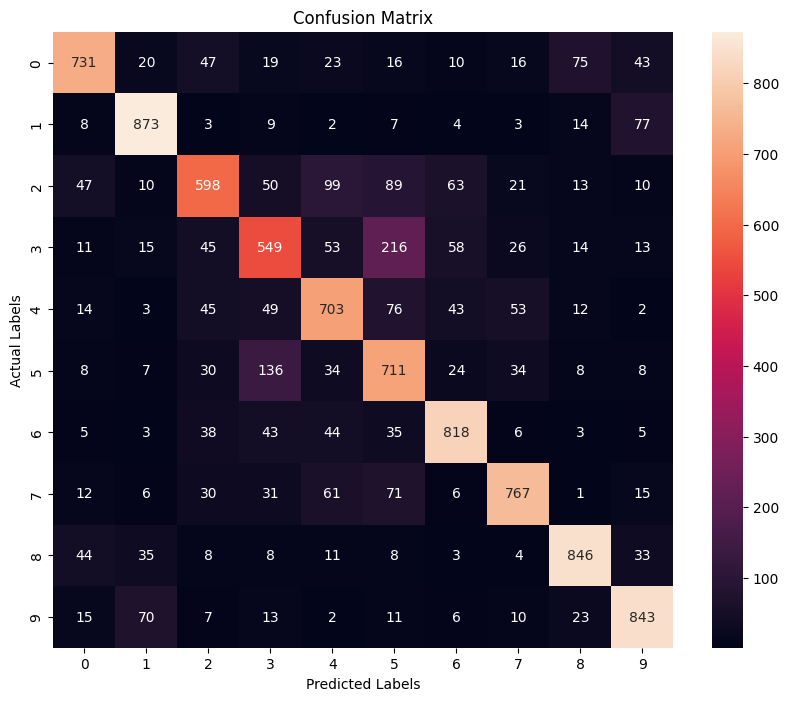

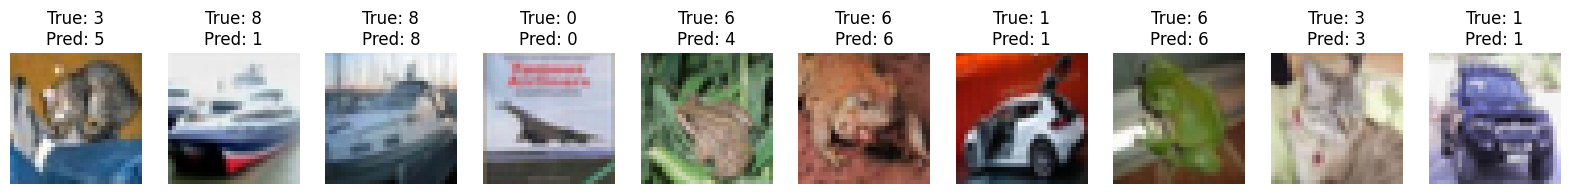

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


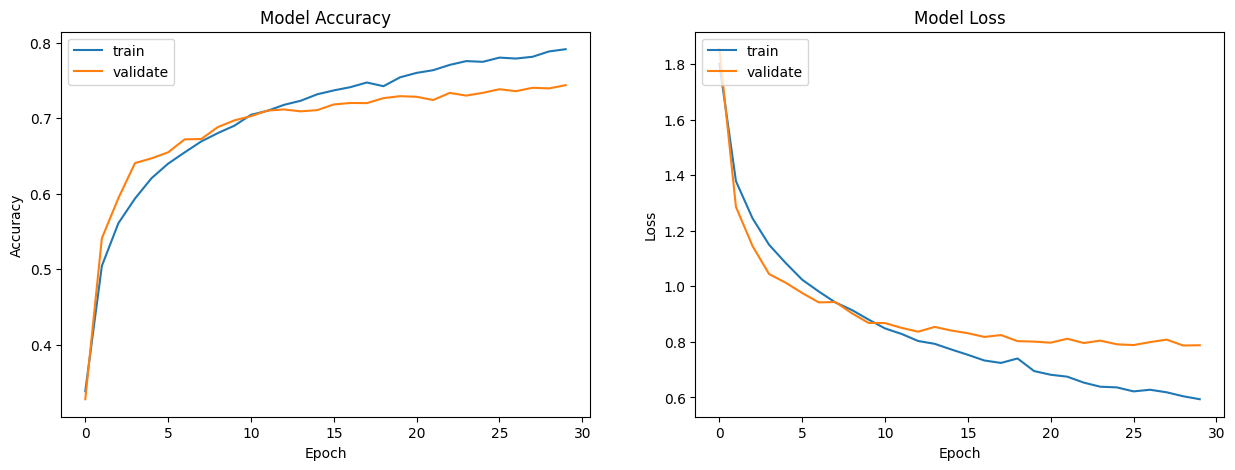

In [4]:
import tensorflow as tf
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from tensorflow_addons.layers import WeightNormalization
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to a 0 to 1 range
X_train, X_val = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
y_train, y_val = to_categorical(y_train, 10), to_categorical(y_test, 10)

# Printing the shape of the dataset to confirm
print("Training data shape:", x_train.shape, y_train.shape)
print("Test data shape:", x_test.shape, y_test.shape)
def build_model(input_shape, num_classes, filters):
    rank = 5
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()
    h4 = H4Layer()
    h5 = H5Layer()
    x = BatchNormalization()(x)

    x = Conv2D(filters=filters, kernel_size=(7, 7), strides=2, padding='same', kernel_initializer="he_normal")(x) #64 Neurons

    x = x_h1 = h1(x)
    x = Conv2D(filters=filters, kernel_size=(5, 5), padding='same', kernel_initializer="glorot_uniform")(x) #CHANGE 64 Neurons && glorot_uniform
    
    x = x_h2 = h2(x, x_h1)
    x_h1 = Conv2D(filters=128,kernel_size=(1, 1), padding='same')(x_h1)  # Ensure h1 and x have the same number of filters
    x_h2 = Conv2D(filters=128, kernel_size=(1, 1), padding='same')(x_h2)  # Ensure h2 and x have the same number of filters
    x = Conv2D(filters=filters*2, kernel_size=(3, 3), padding='same', kernel_initializer="he_normal")(x) #128 Neurons
    
    x = x_h3 = h3(x, x_h1, x_h2)
    x = Conv2D(filters=filters*2, kernel_size=(3, 3), padding='same', kernel_initializer="glorot_uniform")(x) #CHANGE 128 Neurons 
    
    x = x_h4 = h4(x, x_h2, x_h3)

    x = MaxPooling2D((4, 4))(x)
    x = Dropout(rate=0.5)(x)

    x = Flatten()(x)

    output_layer = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (32, 32, 3) # CIFAR-10 images size
num_classes = 10 # Number of classes in CIFAR-10
model_img = build_model(input_shape, num_classes, 64)
model_img.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model_img.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 256
epochs = 30

history = model_img.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = model_img.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_test = X_val
y_true = y_val
y_pred = model_img.predict(X_test)

# Assuming y_true and y_pred are already one-hot encoded, convert them back to class labels
y_true_labels = np.argmax(y_true, axis=1)
y_pred = model_img.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Plotting a confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Displaying a few images with their predictions
num_samples = 10  # Number of samples to display
fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))

for i, ax in enumerate(axes):
    ax.imshow(X_test[i])  # Show the image
    ax.set_title(f"True: {y_true_labels[i]}\nPred: {y_pred_labels[i]}")
    ax.axis('off')

plt.show()

def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

In [5]:
# Clear the session to free up GPU memory
tf.keras.backend.clear_session()

#FORGET PREVIOUS MODEL
del model_img
gc.collect()

7463

## Glorot normal and 2 layers 64 and 2 layers 32

Training data shape: (50000, 32, 32, 3) (50000, 10)
Test data shape: (10000, 32, 32, 3) (10000, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 32, 32, 3)   12          ['input_3[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 conv2d_8 (Conv2D)              (None, 16, 16, 64)   4864        ['batch_normalization_2[0][0]']  
                                                                                              

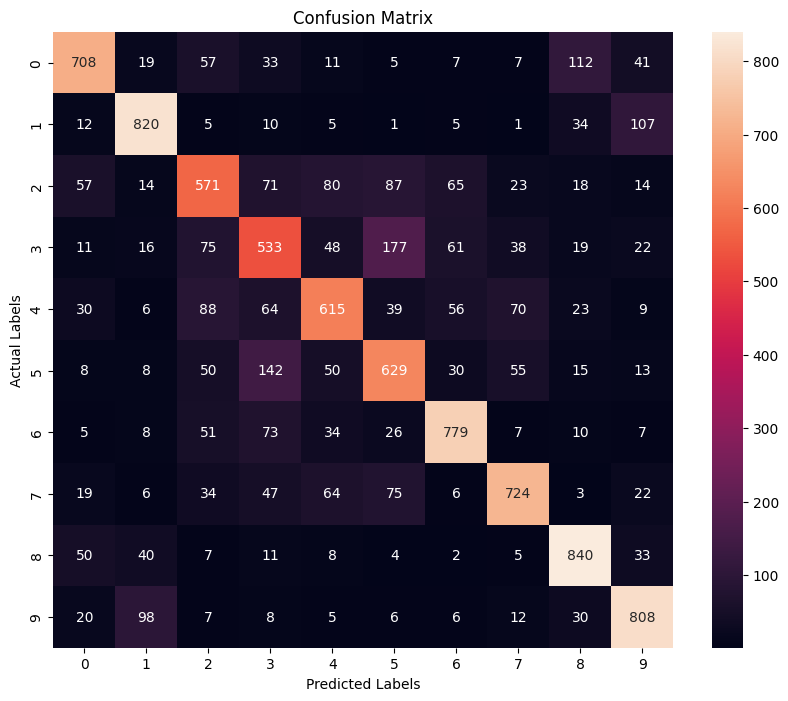

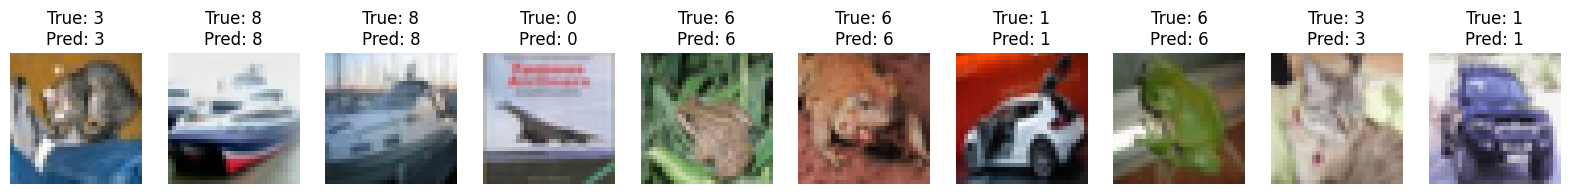

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


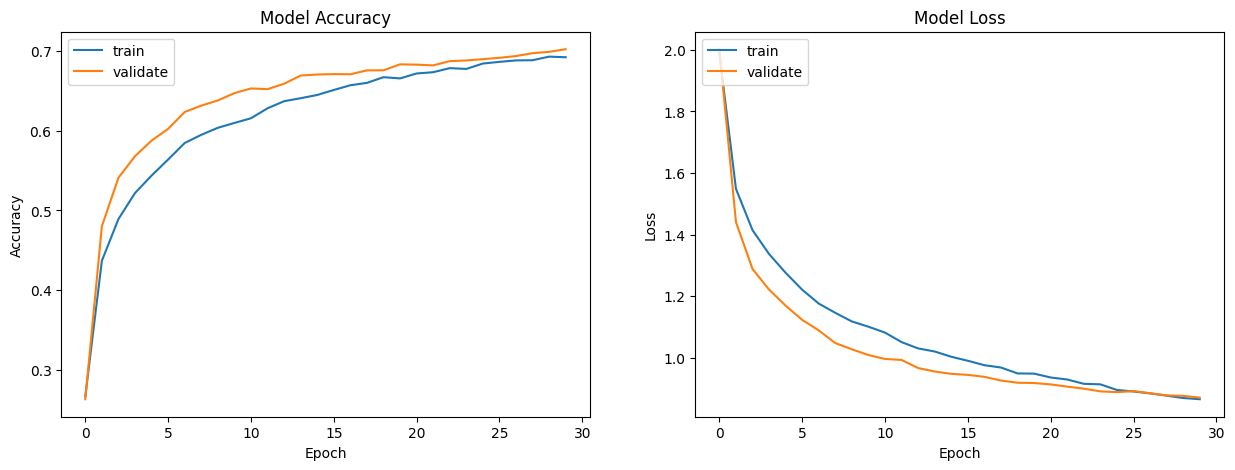

In [8]:
import tensorflow as tf
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from tensorflow_addons.layers import WeightNormalization
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to a 0 to 1 range
X_train, X_val = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
y_train, y_val = to_categorical(y_train, 10), to_categorical(y_test, 10)

# Printing the shape of the dataset to confirm
print("Training data shape:", x_train.shape, y_train.shape)
print("Test data shape:", x_test.shape, y_test.shape)
def build_model(input_shape, num_classes, filters):
    rank = 5
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()
    h4 = H4Layer()
    h5 = H5Layer()
    x = BatchNormalization()(x)

    x = Conv2D(filters=filters, kernel_size=(5, 5), strides=2, padding='same', kernel_initializer="glorot_normal")(x)

    x = x_h1 = h1(x)
    x = Conv2D(filters=filters, kernel_size=(5, 5), padding='same', kernel_initializer="he_normal")(x)
    
    x = x_h2 = h2(x, x_h1)
    x_h1 = Conv2D(filters=filters//2,kernel_size=(1, 1), padding='same')(x_h1)  # Ensure h1 and x have the same number of filters
    x_h2 = Conv2D(filters=filters//2, kernel_size=(1, 1), padding='same')(x_h2)  # Ensure h2 and x have the same number of filters
    x = Conv2D(filters=filters//2, kernel_size=(3, 3), padding='same', kernel_initializer="glorot_normal")(x)
    
    x = x_h3 = h3(x, x_h1, x_h2)
    x = Conv2D(filters=filters//2, kernel_size=(3, 3), padding='same', kernel_initializer="he_normal")(x)
    
    x = x_h4 = h4(x, x_h2, x_h3)

    x = MaxPooling2D((4, 4))(x)
    x = Dropout(rate=0.4)(x)

    x = Flatten()(x)

    output_layer = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 



input_shape = (32, 32, 3) # CIFAR-10 images size
num_classes = 10 # Number of classes in CIFAR-10
model_img = build_model(input_shape, num_classes, 64)
model_img.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model_img.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 256
epochs = 30

history = model_img.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = model_img.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_test = X_val
y_true = y_val
y_pred = model_img.predict(X_test)

# Assuming y_true and y_pred are already one-hot encoded, convert them back to class labels
y_true_labels = np.argmax(y_true, axis=1)
y_pred = model_img.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Plotting a confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Displaying a few images with their predictions
num_samples = 10  # Number of samples to display
fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))

for i, ax in enumerate(axes):
    ax.imshow(X_test[i])  # Show the image
    ax.set_title(f"True: {y_true_labels[i]}\nPred: {y_pred_labels[i]}")
    ax.axis('off')

plt.show()

def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

In [9]:
# Clear the session to free up GPU memory
tf.keras.backend.clear_session()

#FORGET PREVIOUS MODEL
del model_img
gc.collect()

49324

## Lecun normal and 2 layers 128, 2 layers 192 neurons
## Different droppout
## L2 REG

In [2]:
import tensorflow as tf
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from tensorflow_addons.layers import WeightNormalization
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to a 0 to 1 range
X_train, X_val = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
y_train, y_val = to_categorical(y_train, 10), to_categorical(y_test, 10)

# Printing the shape of the dataset to confirm
print("Training data shape:", x_train.shape, y_train.shape)
print("Test data shape:", x_test.shape, y_test.shape)

def build_model(input_shape, num_classes, filters):
    rank = 5
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()
    h4 = H4Layer()
    h5 = H5Layer()
    x = BatchNormalization()(x)

    x = Conv2D(filters=filters, kernel_size=(7, 7), padding='same', kernel_initializer="lecun_normal")(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=filters*2, kernel_size=(5, 5), strides=2, padding='same', kernel_initializer="lecun_normal")(x)

    x = x_h1 = h1(x)
    x = Conv2D(filters=filters*2, kernel_size=(5, 5), padding='same', kernel_initializer="he_normal")(x)
    
    x = x_h2 = h2(x, x_h1)
    # x = Dropout(rate=0.2)(x)
    x_h1 = Conv2D(filters=filters*3, kernel_size=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x_h1)  # Ensure h1 and x have the same number of filters
    x_h2 = Conv2D(filters=filters*3, kernel_size=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x_h2)  # Ensure h2 and x have the same number of filters
    x = Conv2D(filters=filters*3, kernel_size=(3, 3), padding='same', kernel_initializer="lecun_normal")(x)

    x = x_h3 = h3(x, x_h1, x_h2)
    x = Conv2D(filters=filters*3, kernel_size=(3, 3), padding='same', kernel_initializer="he_normal", kernel_regularizer=l2(0.001))(x)
    x = Dropout(rate=0.4)(x)
    x = x_h4 = h4(x, x_h2, x_h3)
    x = Dropout(rate=0.4)(x)
    x = MaxPooling2D((3, 3))(x)

    x = Flatten()(x)
    x = Dropout(rate=0.4)(x)

    output_layer = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)

    return model


input_shape = (32, 32, 3) # CIFAR-10 images size
num_classes = 10 # Number of classes in CIFAR-10
model_img = build_model(input_shape, num_classes, 64)
model_img.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model_img.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 256
epochs = 30

history = model_img.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = model_img.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_test = X_val
y_true = y_val
y_pred = model_img.predict(X_test)

# Assuming y_true and y_pred are already one-hot encoded, convert them back to class labels
y_true_labels = np.argmax(y_true, axis=1)
y_pred = model_img.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Plotting a confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Displaying a few images with their predictions
num_samples = 10  # Number of samples to display
fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))

for i, ax in enumerate(axes):
    ax.imshow(X_test[i])  # Show the image
    ax.set_title(f"True: {y_true_labels[i]}\nPred: {y_pred_labels[i]}")
    ax.axis('off')

plt.show()

def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

Training data shape: (50000, 32, 32, 3) (50000, 10)
Test data shape: (10000, 32, 32, 3) (10000, 1)


2024-06-12 13:29:08.122123: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-12 13:29:08.140494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-12 13:29:08.140650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-12 13:29:08.141044: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 3)   12          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   9472        ['batch_normalization[0][0]']    
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 32, 32, 64)  256         ['conv2d[0][0]']             

2024-06-12 13:29:09.738905: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2024-06-12 13:29:09.841228: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


196/196 [==============================] - 20s 82ms/step - loss: 1.9512 - accuracy: 0.3641 - val_loss: 2.2743 - val_accuracy: 0.2834
Epoch 2/30
196/196 [==============================] - 15s 77ms/step - loss: 1.4438 - accuracy: 0.5270 - val_loss: 1.9375 - val_accuracy: 0.4119
Epoch 3/30
196/196 [==============================] - 15s 77ms/step - loss: 1.3428 - accuracy: 0.5711 - val_loss: 1.9054 - val_accuracy: 0.4554
Epoch 4/30
196/196 [==============================] - 15s 76ms/step - loss: 1.2269 - accuracy: 0.6070 - val_loss: 1.9798 - val_accuracy: 0.4543
Epoch 5/30
196/196 [==============================] - 15s 76ms/step - loss: 1.1648 - accuracy: 0.6287 - val_loss: 1.5681 - val_accuracy: 0.5119
Epoch 6/30
196/196 [==============================] - 15s 75ms/step - loss: 1.1078 - accuracy: 0.6502 - val_loss: 1.6652 - val_accuracy: 0.5109
Epoch 7/30
196/196 [==============================] - 15s 75ms/step - loss: 1.0800 - accuracy: 0.6585 - val_loss: 1.5441 - val_accuracy: 0.5374
Epo

In [ ]:
# Clear the session to free up GPU memory
tf.keras.backend.clear_session()

#FORGET PREVIOUS MODEL
del model_img
gc.collect()

## 32 Neurons all

Training data shape: (50000, 32, 32, 3) (50000, 10)
Test data shape: (10000, 32, 32, 3) (10000, 1)


2024-06-12 11:11:57.238594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-12 11:11:57.266649: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-12 11:11:57.266868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-12 11:11:57.267537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 3)   12          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   4736        ['batch_normalization[0][0]']    
                                                                                                  
 h1_layer (H1Layer)             (None, 16, 16, 32)   32          ['conv2d[0][0]']             

2024-06-12 11:12:00.040885: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2024-06-12 11:12:00.284276: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


196/196 [==============================] - 6s 20ms/step - loss: 2.0316 - accuracy: 0.2574 - val_loss: 1.9552 - val_accuracy: 0.2723
Epoch 2/30
196/196 [==============================] - 3s 16ms/step - loss: 1.5528 - accuracy: 0.4421 - val_loss: 1.4366 - val_accuracy: 0.4898
Epoch 3/30
196/196 [==============================] - 3s 17ms/step - loss: 1.3931 - accuracy: 0.5022 - val_loss: 1.3029 - val_accuracy: 0.5324
Epoch 4/30
196/196 [==============================] - 3s 16ms/step - loss: 1.2992 - accuracy: 0.5369 - val_loss: 1.2302 - val_accuracy: 0.5650
Epoch 5/30
196/196 [==============================] - 3s 17ms/step - loss: 1.2441 - accuracy: 0.5588 - val_loss: 1.1697 - val_accuracy: 0.5834
Epoch 6/30
196/196 [==============================] - 3s 17ms/step - loss: 1.1917 - accuracy: 0.5794 - val_loss: 1.1269 - val_accuracy: 0.5996
Epoch 7/30
196/196 [==============================] - 3s 17ms/step - loss: 1.1497 - accuracy: 0.5922 - val_loss: 1.0925 - val_accuracy: 0.6167
Epoch 8/30

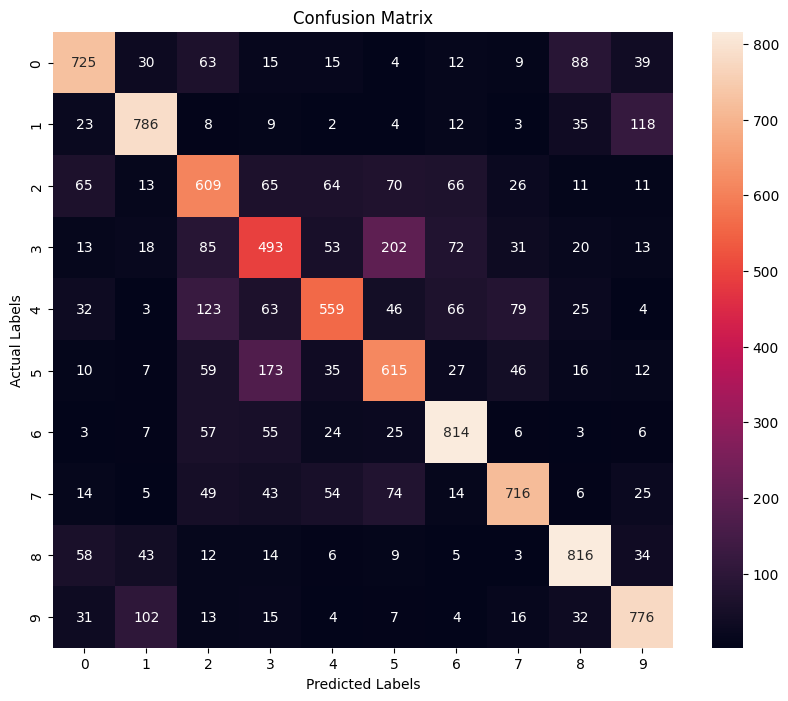

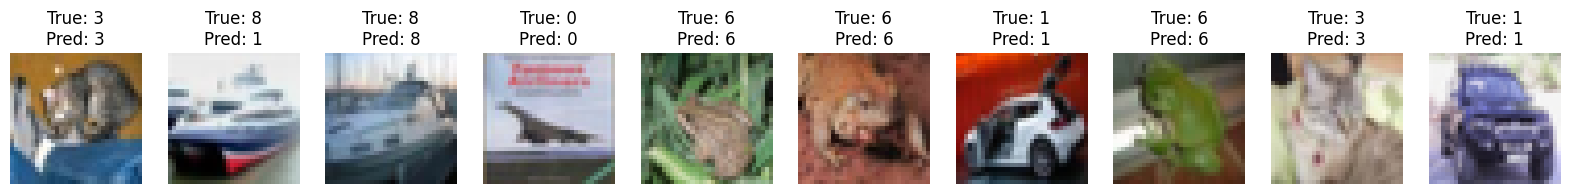

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


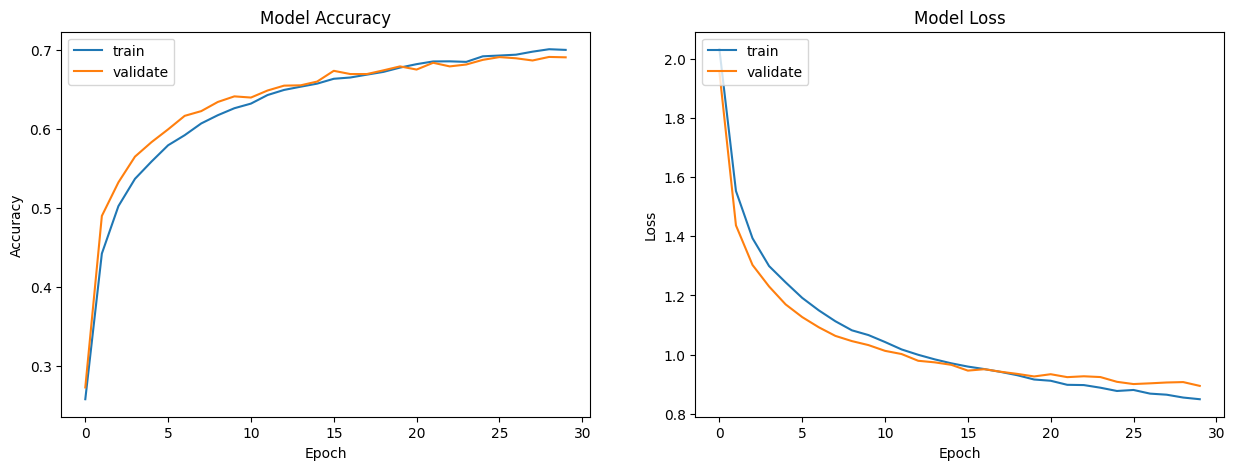

In [2]:
import tensorflow as tf
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from tensorflow_addons.layers import WeightNormalization
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to a 0 to 1 range
X_train, X_val = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
y_train, y_val = to_categorical(y_train, 10), to_categorical(y_test, 10)

# Printing the shape of the dataset to confirm
print("Training data shape:", x_train.shape, y_train.shape)
print("Test data shape:", x_test.shape, y_test.shape)
def build_model(input_shape, num_classes, filters):
    rank = 5
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()
    h4 = H4Layer()
    h5 = H5Layer()
    x = BatchNormalization()(x)

    x = Conv2D(filters=filters//2, kernel_size=(7, 7), strides=2, padding='same', kernel_initializer="he_uniform")(x)

    x = x_h1 = h1(x)
    x = Conv2D(filters=filters//2, kernel_size=(5, 5), padding='same', kernel_initializer="he_uniform")(x)
    
    x = x_h2 = h2(x, x_h1)
    x = Conv2D(filters=filters//2, kernel_size=(3, 3), padding='same', kernel_initializer="he_uniform")(x)
    
    x = x_h3 = h3(x, x_h1, x_h2)
    x = Conv2D(filters=filters//2, kernel_size=(3, 3), padding='same', kernel_initializer="he_uniform")(x)
    
    x = x_h4 = h4(x, x_h2, x_h3)

    x = MaxPooling2D((2, 2))(x)
    x = Dropout(rate=0.5)(x)

    x = Flatten()(x)

    output_layer = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 



input_shape = (32, 32, 3) # CIFAR-10 images size
num_classes = 10 # Number of classes in CIFAR-10
model_img = build_model(input_shape, num_classes, 64)
model_img.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model_img.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 256
epochs = 30

history = model_img.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = model_img.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_test = X_val
y_true = y_val
y_pred = model_img.predict(X_test)

# Assuming y_true and y_pred are already one-hot encoded, convert them back to class labels
y_true_labels = np.argmax(y_true, axis=1)
y_pred = model_img.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Plotting a confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Displaying a few images with their predictions
num_samples = 10  # Number of samples to display
fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))

for i, ax in enumerate(axes):
    ax.imshow(X_test[i])  # Show the image
    ax.set_title(f"True: {y_true_labels[i]}\nPred: {y_pred_labels[i]}")
    ax.axis('off')

plt.show()

def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

In [3]:
# Clear the session to free up GPU memory
tf.keras.backend.clear_session()

#FORGET PREVIOUS MODEL
del model_img
gc.collect()

22356

# all glorot normal 2 64 neurons, 2 128 neurons

Training data shape: (50000, 32, 32, 3) (50000, 10)
Test data shape: (10000, 32, 32, 3) (10000, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 3)   12          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   9472        ['batch_normalization[0][0]']    
                                                                                              

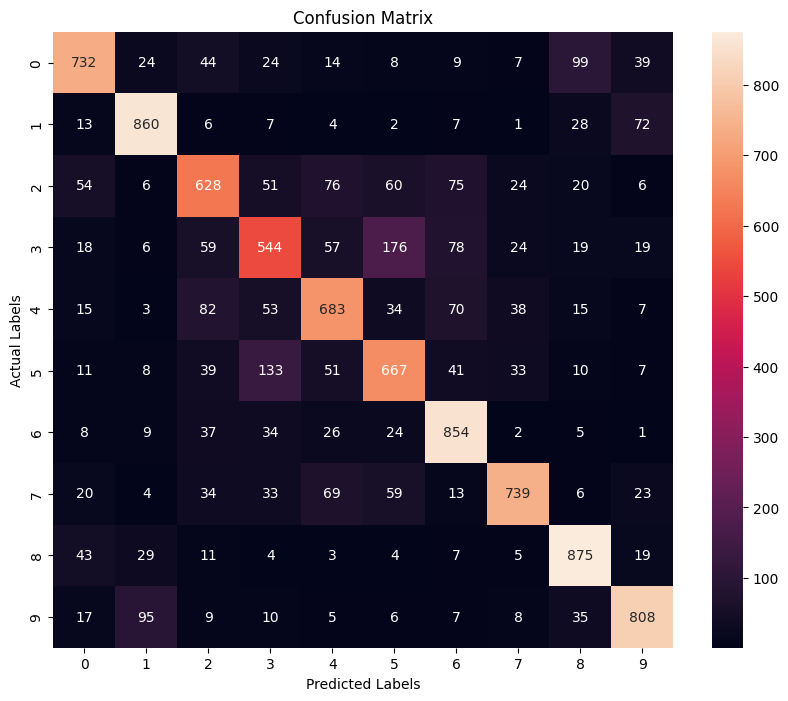

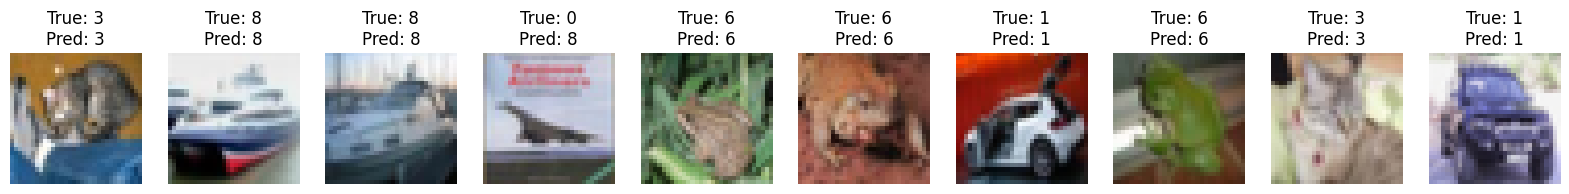

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


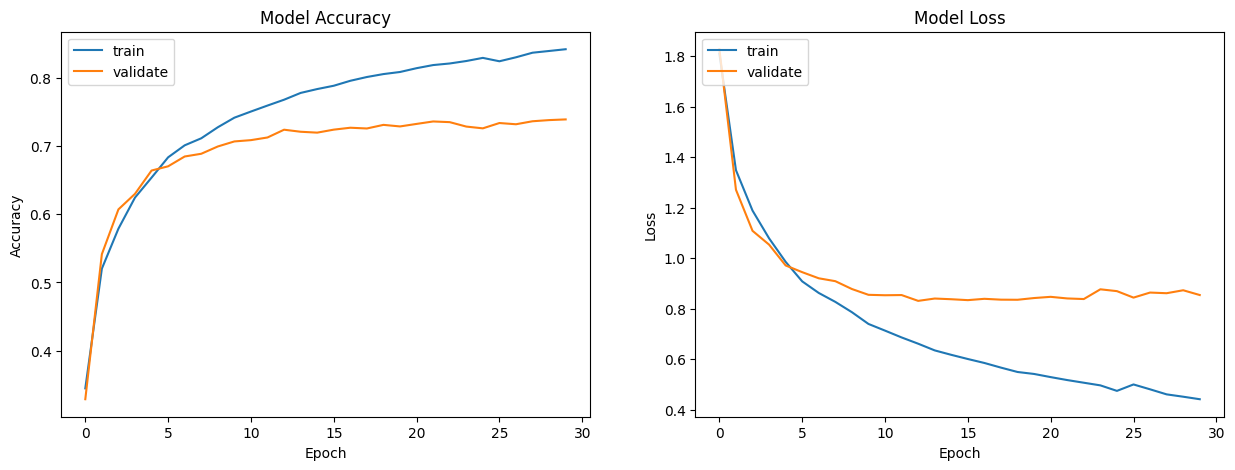

In [4]:
import tensorflow as tf
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from tensorflow_addons.layers import WeightNormalization
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to a 0 to 1 range
X_train, X_val = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
y_train, y_val = to_categorical(y_train, 10), to_categorical(y_test, 10)

# Printing the shape of the dataset to confirm
print("Training data shape:", x_train.shape, y_train.shape)
print("Test data shape:", x_test.shape, y_test.shape)
def build_model(input_shape, num_classes, filters):
    rank = 5
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()
    h4 = H4Layer()
    h5 = H5Layer()
    x = BatchNormalization()(x)

    x = Conv2D(filters=filters, kernel_size=(7, 7), strides=1, padding='same', kernel_initializer="glorot_normal")(x)

    x = x_h1 = h1(x)
    x = Conv2D(filters=filters, kernel_size=(5, 5), padding='same', kernel_initializer="glorot_normal")(x)
    
    x = x_h2 = h2(x, x_h1)
    x_h1 = Conv2D(filters=filters*2,kernel_size=(1, 1), padding='same')(x_h1)  # Ensure h1 and x have the same number of filters
    x_h2 = Conv2D(filters=filters*2, kernel_size=(1, 1), padding='same')(x_h2)  # Ensure h2 and x have the same number of filters

    x = Conv2D(filters=filters*2, kernel_size=(3, 3), padding='same', kernel_initializer="glorot_normal")(x)
    
    x = x_h3 = h3(x, x_h1, x_h2)
    x = Conv2D(filters=filters*2, kernel_size=(3, 3), padding='same', kernel_initializer="glorot_normal")(x)
    
    x = x_h4 = h4(x, x_h2, x_h3)

    x = MaxPooling2D((4, 4))(x)
    x = Dropout(rate=0.4)(x)

    x = Flatten()(x)

    output_layer = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (32, 32, 3) # CIFAR-10 images size
num_classes = 10 # Number of classes in CIFAR-10
model_img = build_model(input_shape, num_classes, 64)
model_img.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model_img.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 256
epochs = 30

history = model_img.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = model_img.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_test = X_val
y_true = y_val
y_pred = model_img.predict(X_test)

# Assuming y_true and y_pred are already one-hot encoded, convert them back to class labels
y_true_labels = np.argmax(y_true, axis=1)
y_pred = model_img.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Plotting a confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Displaying a few images with their predictions
num_samples = 10  # Number of samples to display
fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))

for i, ax in enumerate(axes):
    ax.imshow(X_test[i])  # Show the image
    ax.set_title(f"True: {y_true_labels[i]}\nPred: {y_pred_labels[i]}")
    ax.axis('off')

plt.show()

def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

# GPT ADAPTED

In [2]:
import tensorflow as tf
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from tensorflow_addons.layers import WeightNormalization
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to a 0 to 1 range
X_train, X_val = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
y_train, y_val = to_categorical(y_train, 10), to_categorical(y_test, 10)

# Printing the shape of the dataset to confirm
print("Training data shape:", x_train.shape, y_train.shape)
print("Test data shape:", x_test.shape, y_test.shape)

def build_model(input_shape, num_classes, filters):
    regularization_strength = 0.0001  # Adjust this value if necessary

    input_layer = Input(shape=input_shape)
    x = input_layer

    # Initial Convolutional Layer
    x = Conv2D(filters=filters, kernel_size=(7, 7), padding='same', kernel_initializer="lecun_normal", kernel_regularizer=l2(regularization_strength))(x)
    x = BatchNormalization()(x)
    
    # First Set of Layers
    x = Conv2D(filters=filters*2, kernel_size=(5, 5), strides=2, padding='same', kernel_initializer="lecun_normal", kernel_regularizer=l2(regularization_strength))(x)
    x = BatchNormalization()(x)
    
    # Custom Activation Layers
    x = x_h1 = H1Layer()(x)
    x = Conv2D(filters=filters*2, kernel_size=(5, 5), padding='same', kernel_initializer="he_normal", kernel_regularizer=l2(regularization_strength))(x)
    # x = BatchNormalization()(x)
    
    x = x_h2 = H2Layer()(x, x_h1)
    x_h1 = Conv2D(filters=filters*3, kernel_size=(1, 1), padding='same', kernel_regularizer=l2(regularization_strength))(x_h1)  # Ensure h1 and x have the same number of filters
    x_h2 = Conv2D(filters=filters*3, kernel_size=(1, 1), padding='same', kernel_regularizer=l2(regularization_strength))(x_h2)  # Ensure h2 and x have the same number of filters
    x = Conv2D(filters=filters*3, kernel_size=(3, 3), padding='same', kernel_initializer="lecun_normal", kernel_regularizer=l2(regularization_strength))(x)
    # x = BatchNormalization()(x)

    x = x_h3 = H3Layer()(x, x_h1, x_h2)
    x = Conv2D(filters=filters*3, kernel_size=(3, 3), padding='same', kernel_initializer="he_normal", kernel_regularizer=l2(regularization_strength))(x)
    x = Dropout(rate=0.3)(x)
    # x = BatchNormalization()(x)
    
    x = x_h4 = H4Layer()(x, x_h2, x_h3)
    x = Conv2D(filters=filters*3, kernel_size=(3, 3), padding='same', kernel_initializer="lecun_normal", kernel_regularizer=l2(regularization_strength))(x)
    x = Dropout(rate=0.4)(x)
    # x = BatchNormalization()(x)
    
    # Pooling and Flattening
    x = MaxPooling2D((3, 3))(x)
    x = Flatten()(x)
    
    # Fully Connected Layer
    x = Dense(filters*3, activation='relu', kernel_regularizer=l2(regularization_strength))(x)
    x = Dropout(rate=0.5)(x)
    
    # Output Layer
    output_layer = Dense(num_classes, activation='softmax', kernel_regularizer=l2(regularization_strength))(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)

    return model


input_shape = (32, 32, 3) # CIFAR-10 images size
num_classes = 10 # Number of classes in CIFAR-10
model_img = build_model(input_shape, num_classes, 32)
model_img.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model_img.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 128
epochs = 30

history = model_img.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = model_img.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_test = X_val
y_true = y_val
y_pred = model_img.predict(X_test)

# Assuming y_true and y_pred are already one-hot encoded, convert them back to class labels
y_true_labels = np.argmax(y_true, axis=1)
y_pred = model_img.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Plotting a confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Displaying a few images with their predictions
num_samples = 10  # Number of samples to display
fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))

for i, ax in enumerate(axes):
    ax.imshow(X_test[i])  # Show the image
    ax.set_title(f"True: {y_true_labels[i]}\nPred: {y_pred_labels[i]}")
    ax.axis('off')

plt.show()

def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

Training data shape: (50000, 32, 32, 3) (50000, 10)
Test data shape: (10000, 32, 32, 3) (10000, 1)


2024-06-12 13:35:17.673137: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-12 13:35:17.687800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-12 13:35:17.687935: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-12 13:35:17.688363: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 128)  204928      ['batch_normalization[0][0]']

2024-06-12 13:35:19.302429: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2024-06-12 13:35:19.398385: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 39/196 [====>.........................] - ETA: 13s - loss: 2.4507 - accuracy: 0.0991